<a href="https://colab.research.google.com/github/pranavkrish2005/credit-card-fraud-detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install scikeras


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Credit Card Fraud Detection") \
    .getOrCreate()

In [60]:
# Load the data into a Spark DataFrame
df_spark = spark.read.csv("creditcard.csv", header=True, inferSchema=True)
df = df_spark.toPandas()
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Outlier detection and deletion

## Visaulizing outliers

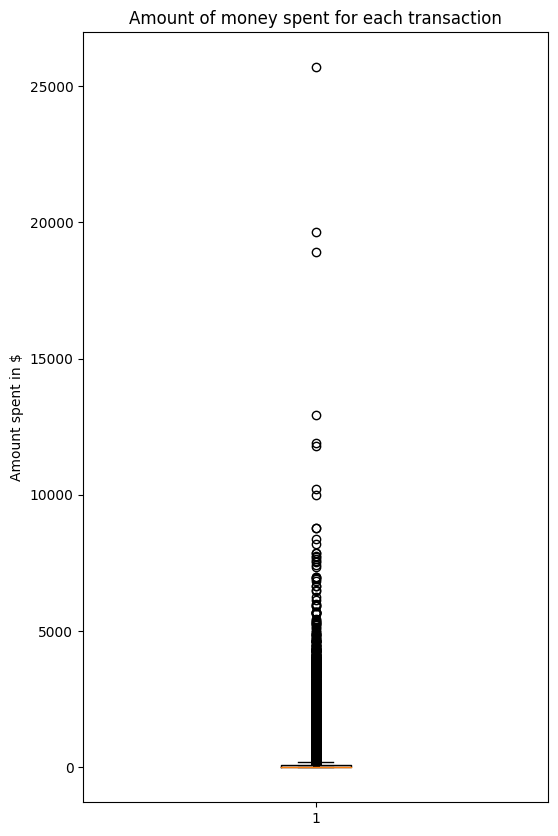

In [62]:
plt.figure(figsize=(6, 10))
plt.boxplot(df['Amount'])
plt.title("Amount of money spent for each transaction")
plt.ylabel('Amount spent in $')
plt.show()

## Removing outliers

In [63]:
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [64]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [65]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [66]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
204592,-0.208622,0.595108,-0.842239,0.736498,0.043439,-3.811789,0.270703,-1.674271,0.982661,0.143312,...,-0.366147,-0.090282,-0.377566,-0.096562,1.048185,0.247185,-1.342585,-0.013840,0.064827,0
9252,-0.293440,-0.838461,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-3.179949,-9.252794,4.245062,...,1.305862,1.846165,-0.267172,-0.310804,-1.201685,1.352176,0.608425,1.574715,0.808725,1
3400,-0.293440,-0.960655,-1.055570,0.667092,0.774202,-2.244574,0.419298,-1.087666,0.990313,-0.334796,...,0.008858,0.045195,0.592725,-0.119086,-0.003222,0.164419,-0.843730,0.128542,-0.000466,0
6903,-0.293440,-0.890588,-2.535852,5.793644,-7.618463,6.395830,-0.065210,-3.136372,-3.104557,1.823233,...,0.408704,0.716720,-0.448060,-0.402407,-0.288835,1.011752,0.425965,0.413140,0.308205,1
248296,-0.307413,0.812780,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,...,0.354773,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


<ipython-input-67-e38a3b89b8e8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=new_df, palette=colors)


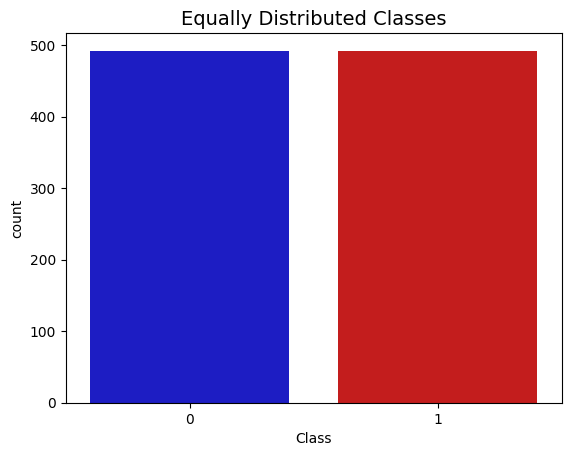

In [67]:
colors = ["#0101DF", "#DF0101"]

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts() / len(new_df))

# Corrected countplot syntax
sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [68]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [69]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))
print("XGBClassifier-AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92        87
           1       0.98      0.89      0.93       110

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

ROC-AUC: 0.9339602925809822
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        87
           1       0.97      0.90      0.93       110

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

XGBClassifier-AUC: 0.9327586206896551


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6438 - loss: 0.6069
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9302 - loss: 0.2888
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9370 - loss: 0.2322
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9247 - loss: 0.2088 
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9409 - loss: 0.1593 
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9554 - loss: 0.1282  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1128 
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9456 - loss: 0.1240  
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9634 - loss: 0.1020 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.1084 
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9652 - loss: 0.0934 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9766 - los

In [72]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")

7/7 - 0s - 24ms/step - accuracy: 0.9340 - loss: 0.3627
Test Accuracy: 0.9340101480484009


In [73]:
from scikeras.wrappers import KerasClassifier

# Define a function that returns the compiled Keras model
def create_nn_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier
nn_classifier = KerasClassifier(build_fn=create_nn_model, epochs=20, batch_size=32, verbose=0)


In [74]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier with the wrapped Keras model, Random Forest, and XGBoost
voting_clf = VotingClassifier(estimators=[
    ('nn', nn_classifier),  # Wrapped Keras Sequential model
    ('rf', rf),             # Random Forest
    ('xgb', xgb)            # XGBoost
], voting='soft')            # 'soft' for probability-based voting

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred_voting = voting_clf.predict(X_test)
print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        87
           1       0.98      0.90      0.94       110

    accuracy                           0.93       197
   macro avg       0.93      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197



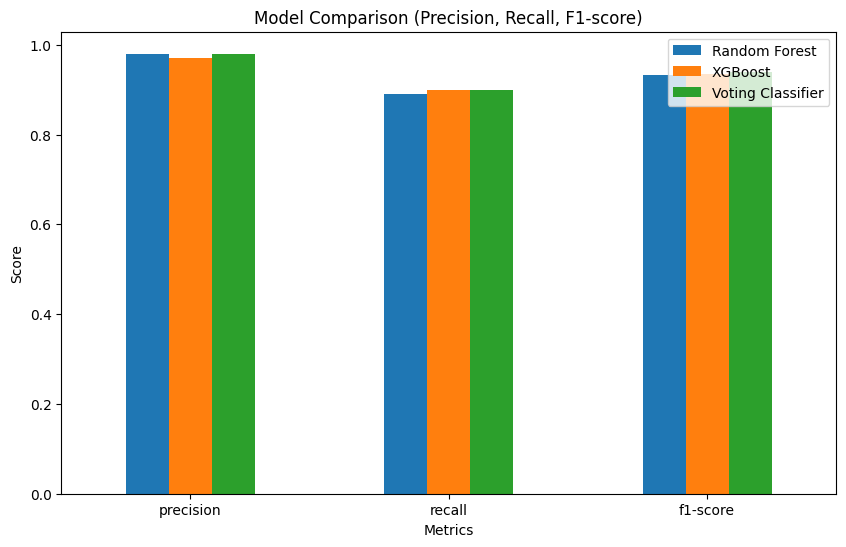

In [75]:
from sklearn.metrics import classification_report

# Get classification reports for individual models
rf_report = classification_report(y_test, rf.predict(X_test), output_dict=True)
xgb_report = classification_report(y_test, xgb.predict(X_test), output_dict=True)
voting_report = classification_report(y_test, voting_clf.predict(X_test), output_dict=True)

# Extract precision, recall, f1-score for the "1" (positive class)
metrics = ['precision', 'recall', 'f1-score']
rf_scores = [rf_report['1'][metric] for metric in metrics]
xgb_scores = [xgb_report['1'][metric] for metric in metrics]
voting_scores = [voting_report['1'][metric] for metric in metrics]

df = pd.DataFrame({
    'Metrics': metrics,
    'Random Forest': rf_scores,
    'XGBoost': xgb_scores,
    'Voting Classifier': voting_scores
})

# Plot the results
df.set_index('Metrics').plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


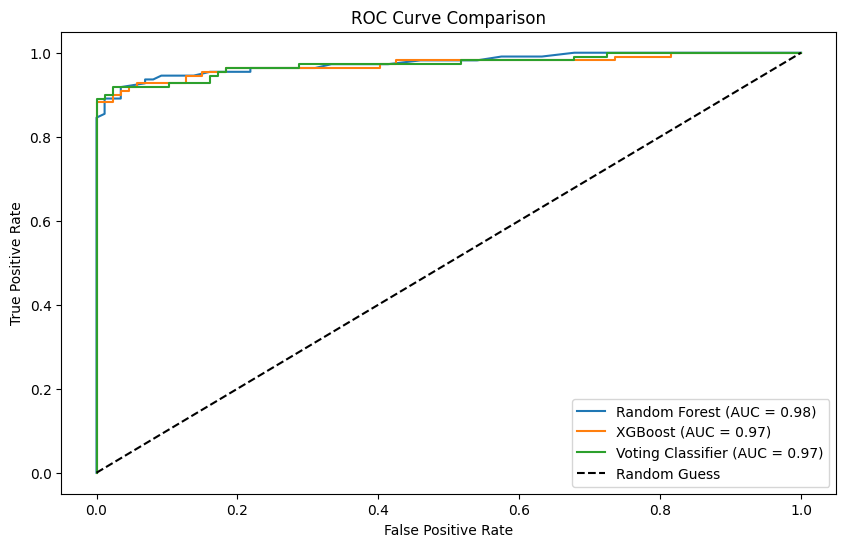

In [76]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each classifier
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]
voting_probs = voting_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
voting_fpr, voting_tpr, _ = roc_curve(y_test, voting_probs)

rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)
voting_auc = auc(voting_fpr, voting_tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(voting_fpr, voting_tpr, label=f'Voting Classifier (AUC = {voting_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()